# Kalman Filter
A GOOD SOURCE: https://www.kalmanfilter.net/default.aspx

What is a Kalman Filter? It is a probabilistical model that combines **prediction + measurement**

Problem:
You have a system that evolves over time — like a car moving along a road — but:
- You can only measure it with noise (e.g., GPS errors).
- You have a prediction model (e.g., physics).

Goal: Estimate the best guess for the true position (and maybe velocity), at each step, using:
- The noisy measurements.
- The model’s prediction.

How?  Kalman filter is like dynamic Bayesian updating:
- **Predict** where you think the system should be and **measure** where it probably is.
- Combine both probabilistically.



## Simple Example
Imagine: A car driving in 1D.

You want to estimate its position.

You have:
- Model: Position at next step ≈ previous + constant velocity.
- Measurement: GPS gives position, but with ±5m noise.

### Kalman Filter Steps
Each time step:

- 1) Predict: Where will the car be?
- 2) Measure: What does GPS say?
- 3) Update: Combine prediction + measurement → new best estimate.


### Example Numbers
Suppose:

- Initial position: 0 m
- Velocity: 1 m/s
- Measurement noise std: 5 m
- Assume perfect velocity known for simplicity.


# 1. What does the code do?

This is a **1D constant-velocity Kalman filter** estimating the position of an object moving at a known constant velocity (**1 m/s**).

- The true position evolves by:  
  $$
  x_{k} = x_{k-1} + v \cdot \Delta t
  $$
- The **measurement** is the true position plus some **Gaussian noise** (like GPS noise).
- The **Kalman filter** tries to estimate the true position given these noisy measurements.

---

# 2. Equations used

## 🔹 Prediction (Time Update)

- Predicted state estimate:  
  $$
  \hat{x}_{k|k-1} = \hat{x}_{k-1|k-1} + v \cdot \Delta t
  $$

- Predicted estimate uncertainty:  
  $$
  P_{k|k-1} = P_{k-1|k-1} + Q
  $$

---

##  Correction (Measurement Update)

- **Kalman Gain**:  
  $$
  K_{k} = \frac{P_{k|k-1}}{P_{k|k-1} + R}
  $$

- Updated state estimate:  
  $$
  \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_{k} \big( z_{k} - \hat{x}_{k|k-1} \big)
  $$

- Updated estimate uncertainty:  
  $$
  P_{k|k} = (1 - K_{k}) P_{k|k-1}
  $$

---

# 3. Manual example for first 3 steps

Suppose:
- $dt = 1\,s$
- $v = 1\,m/s$
- $Q = 0$
- $R = 5^2 = 25$
- Initial estimate: $\hat{x}_0 = 0$
- Initial uncertainty: $P_0 = 1$

Assume noisy measurements:
- True positions: [0, 1, 2, 3]
- Fake measurements: [2, 0, 4]

---

##  Step 1

**Prediction:**  
$$
x_{pred} = 0 + 1 = 1 \\
P_{pred} = 1 + 0 = 1
$$

**Update:**  
$$
K = \frac{1}{1+25} = 0.0385 \\
x_{est} = 1 + 0.0385 \times (2 - 1) = 1.0385 \\
P = (1 - 0.0385) \times 1 = 0.9615
$$

---

##  Step 2

**Prediction:**  
$$
x_{pred} = 1.0385 + 1 = 2.0385 \\
P_{pred} = 0.9615
$$

**Update:**  
$$
K = \frac{0.9615}{0.9615 + 25} = 0.0372 \\
x_{est} = 2.0385 + 0.0372 \times (0 - 2.0385) = 1.9626 \\
P = (1 - 0.0372) \times 0.9615 = 0.9259
$$

---

##  Step 3

**Prediction:**  
$$
x_{pred} = 1.9626 + 1 = 2.9626 \\
P_{pred} = 0.9259
$$

**Update:**  
$$
K = \frac{0.9259}{0.9259 + 25} = 0.0354 \\
x_{est} = 2.9626 + 0.0354 \times (4 - 2.9626) = 2.9993 \\
P = (1 - 0.0354) \times 0.9259 = 0.8933
$$

---

# 4. Summary table

| Step | Measurement | Prediction | Estimate | Kalman Gain |
|------|--------------|------------|----------|--------------|
| 1 | 2 | 1 | 1.0385 | 0.0385 |
| 2 | 0 | 2.0385 | 1.9626 | 0.0372 |
| 3 | 4 | 2.9626 | 2.9993 | 0.0354 |


first 4 estimates: [0.8906326137944846, 1.9136678688778304, 2.9916633160673287, 3.978366925721481]


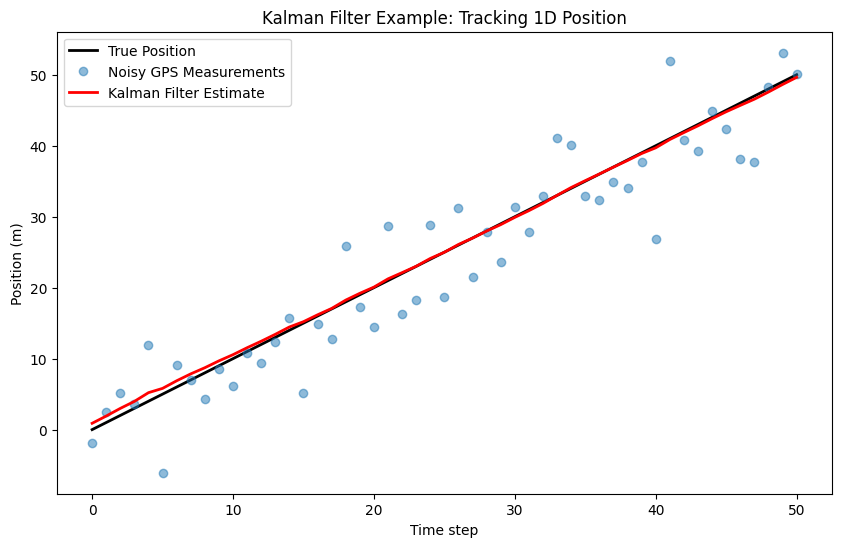

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated true position
dt = 1  # time step in seconds
n_steps = 50
velocity = 1  # m/s

true_positions = [0]
for _ in range(n_steps):
    true_positions.append(true_positions[-1] + velocity * dt)

# Simulated noisy GPS measurements
measurement_noise_std = 5
measurements = [pos + np.random.normal(0, measurement_noise_std) for pos in true_positions]

# Kalman filter setup
# Initial guess
x_est = 0
P = 1  # Initial estimate uncertainty

# Model: position += velocity * dt
# Measurement: position with noise

Q = 0  # Process noise (assume perfect motion for simplicity)
R = measurement_noise_std**2  # Measurement noise variance

estimates = []

for z in measurements:
    # 1. Prediction step
    x_pred = x_est + velocity * dt
    P_pred = P + Q
    
    # 2. Update step
    K = P_pred / (P_pred + R)  # Kalman gain
    x_est = x_pred + K * (z - x_pred)
    P = (1 - K) * P_pred
    
    estimates.append(x_est)

print(f"first 4 estimates: {estimates[:4]}")
# Plot
plt.figure(figsize=(10,6))
plt.plot(true_positions, label='True Position', color='k', lw=2)
plt.plot(measurements, 'o', label='Noisy GPS Measurements', alpha=0.5)
plt.plot(estimates, '-r', lw=2, label='Kalman Filter Estimate')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Position (m)')
plt.title('Kalman Filter Example: Tracking 1D Position')
plt.show()


This shows how probability and noise are used to combine models + measurements.

The Kalman gain K balances:
- Trust model more? (low measurement noise) → less correction.
- Trust measurement more? (high model uncertainty) → bigger correction.